In [ ]:
# Follow the installation instructions based on https://docs.rapids.ai/install/ and run this jupyter notebook on a rapids python kernel
# I prefer WSL2 SDK manager as the way to grab it and then follow the installation steps
!pip install pandas
!pip install arff
!pip install numpy
!pip install scikit-learn
!pip install seaborn


In [ ]:
import pandas as pd
from scipy.io import arff
import arff, numpy as np
import cupy as cp
import cudf
from cuml.preprocessing import LabelEncoder
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score
#loads the dataset from folder of notebook

dataset= arff.load(open('dataset.arff', 'r'))
data = np.array(dataset['data'])


In [3]:
#testing to make sure rapid is working
print(cudf.Series([1, 2, 3]))

0    1
1    2
2    3
dtype: int64


In [4]:
from cuml.preprocessing import LabelEncoder
from cuml.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import datetime

In [ ]:
column_names = [
    "seqid", "date_of_stop", "time_of_stop", "agency", "subagency", "description", "location",
    "latitude", "longitude", "accident", "belts", "personal_injury", "property_damage", "fatal",
    "commercial_license", "hazmat", "commercial_vehicle", "alcohol", "work_zone", "search_conducted",
    "search_disposition", "search_outcome", "search_reason", "search_reason_for_stop", "search_type",
    "search_arrest_reason", "state", "vehicletype", "year", "make", "model", "color",
    "violation_type", "charge", "article", "contributed_to_accident", "race", "gender",
    "driver_city", "driver_state", "dl_state", "arrest_type", "geolocation"
]
df = pd.DataFrame(data, columns=column_names)
for col in df.select_dtypes(include="object").columns:
    try:
        df[col] = df[col].astype(str)
    except Exception as e:
        print(f"Failed to convert {col} to string:", e)
#names all the columns and if the column is not already a string, converts it to a string for ease of manipulation


In [6]:

df['date_of_stop'] = pd.to_datetime(df['date_of_stop'],errors='coerce')

# Create the derived column 'day_of_week'
df['day_of_week'] = df['date_of_stop'].dt.day_name()
# Optionally, inspect the new column
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# turning time from string to a better one to encode
# Convert the time_of_stop column to a datetime time (you might need to adjust the format)
df['time_of_stop'] = pd.to_datetime(df['time_of_stop'], format='%H:%M:%S', errors='coerce')

# Extract the hour as a decimal including minutes (if desired)
df['hour_decimal'] = df['time_of_stop'].dt.hour + df['time_of_stop'].dt.minute / 60.0

# Create cyclic features
# For a full day, use 24 hours as the period
df['time_sin'] = np.sin(2 * np.pi * df['hour_decimal'] / 24)
df['time_cos'] = np.cos(2 * np.pi * df['hour_decimal'] / 24)

# Optionally, drop the original time_of_stop and hour_decimal columns if you don't need them
df.drop(['time_of_stop', 'hour_decimal'], axis=1, inplace=True)

print(df.head())



                                  seqid date_of_stop agency  \
0  fdcc1a6b-4854-4cde-bb60-248f478fa5b6   2019-09-11    MCP   
1  842dad60-5edf-47a8-9e94-c7e6da729498   2019-09-11    MCP   
2  4db837cc-f2fa-4a5b-9ac8-37698492b5f9   2019-09-11    MCP   
3  79761295-50f6-4336-8b48-fdf55e87a326   2019-09-11    MCP   
4  f9a7a508-386c-466e-95b2-dbf26d7d59fe   2019-09-11    MCP   

                 subagency                                        description  \
0   2nd District, Bethesda                                    STOP LIGHTS (*)   
1  1st District, Rockville  DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...   
2  1st District, Rockville  FAILURE VEH. TO YIELD INTERSECTION RIGHT-OF-WA...   
3   2nd District, Bethesda  DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...   
4    4th District, Wheaton       MOTOR VEH. W/O REQUIRED STOP LAMPS EQUIPMENT   

                           location   latitude  longitude accident belts  ...  \
0               27 @ SWEEPSTAKES RD  39.259627 -77.22

In [ ]:
#load dataframe to gpu
df = cudf.DataFrame.from_pandas(df)


In [8]:
df.head()

,seqid,date_of_stop,agency,subagency,description,location,latitude,longitude,accident,belts,...,race,gender,driver_city,driver_state,dl_state,arrest_type,geolocation,day_of_week,time_sin,time_cos
0,fdcc1a6b-4854-4cde-bb60-248f478fa5b6,2019-09-11,MCP,"2nd District, Bethesda",STOP LIGHTS (*),27 @ SWEEPSTAKES RD,39.259627,-77.223760,No,No,...,HISPANIC,F,DAMASCUS,MD,MD,B - Unmarked Patrol,"(39.2596266666667, -77.22376)",Wednesday,0.515038,-0.857167
1,842dad60-5edf-47a8-9e94-c7e6da729498,2019-09-11,MCP,"1st District, Rockville",DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...,FREDERICK RD / REDLAND RD,39.112860,-77.162435,No,No,...,BLACK,M,TEMPLE HILLS,MD,MD,A - Marked Patrol,"(39.11286, -77.162435)",Wednesday,0.566406,-0.824126
2,4db837cc-f2fa-4a5b-9ac8-37698492b5f9,2019-09-11,MCP,"1st District, Rockville",FAILURE VEH. TO YIELD INTERSECTION RIGHT-OF-WA...,S/B GEORGIA AVE AT MD200,39.117080,-77.068113,No,No,...,WHITE,M,OLNEY,MD,MD,A - Marked Patrol,"(39.11708, -77.0681133333333)",Wednesday,0.587785,-0.809017
3,79761295-50f6-4336-8b48-fdf55e87a326,2019-09-11,MCP,"2nd District, Bethesda",DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...,OLD GEORGETOWN RD AT MCKINLEY ST,38.991630,-77.105873,No,No,...,BLACK,F,GAITHERSBURG,MD,MD,A - Marked Patrol,"(38.99163, -77.1058733333333)",Wednesday,0.598325,-0.801254
4,f9a7a508-386c-466e-95b2-dbf26d7d59fe,2019-09-11,MCP,"4th District, Wheaton",MOTOR VEH. W/O REQUIRED STOP LAMPS EQUIPMENT,CONNECTICUT AVE / WELLER RD,39.064560,-77.073673,No,No,...,BLACK,F,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.06456, -77.0736733333333)",Wednesday,0.608761,-0.793353


In [9]:
#we're going to ignore the sequence id and date of stop as those should not be useful for classification as sequid is unique and the only new dates can be future ones
#also going to drop description as slight differences in terminology likely is not worth the effort to encode it
#we will drop location as the latitude and longitude already encode it
#going to drop geoloc since latitude and longitude are already columns
# going to drop make, model, charge, reason for stop, and city due to high cardinality

df_reduced = df.drop(["seqid", "date_of_stop","description", "location", "geolocation", "make", "model", "charge", "driver_city", "search_reason_for_stop"], axis=1)
df_reduced.head()


,agency,subagency,latitude,longitude,accident,belts,personal_injury,property_damage,fatal,commercial_license,...,article,contributed_to_accident,race,gender,driver_state,dl_state,arrest_type,day_of_week,time_sin,time_cos
0,MCP,"2nd District, Bethesda",39.259627,-77.223760,No,No,No,No,No,No,...,None,False,HISPANIC,F,MD,MD,B - Unmarked Patrol,Wednesday,0.515038,-0.857167
1,MCP,"1st District, Rockville",39.112860,-77.162435,No,No,No,No,No,No,...,Transportation Article,False,BLACK,M,MD,MD,A - Marked Patrol,Wednesday,0.566406,-0.824126
2,MCP,"1st District, Rockville",39.117080,-77.068113,No,No,No,No,No,No,...,Transportation Article,False,WHITE,M,MD,MD,A - Marked Patrol,Wednesday,0.587785,-0.809017
3,MCP,"2nd District, Bethesda",38.991630,-77.105873,No,No,No,No,No,No,...,Transportation Article,False,BLACK,F,MD,MD,A - Marked Patrol,Wednesday,0.598325,-0.801254
4,MCP,"4th District, Wheaton",39.064560,-77.073673,No,No,No,No,No,No,...,Transportation Article,False,BLACK,F,MD,MD,A - Marked Patrol,Wednesday,0.608761,-0.793353


In [10]:
#Encode categorical columns
categorical_cols = df_reduced.select_dtypes(include=["object"]).columns
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_reduced[col] = le.fit_transform(df_reduced[col].astype("str"))
    le_dict[col] = le
    violation_label_map = {
        i: label for i, label in enumerate(le.classes_.to_arrow().to_pylist())
    }
    print(violation_label_map)



{0: 'MCP'}
{0: '1st District, Rockville', 1: '2nd District, Bethesda', 2: '3rd District, Silver Spring', 3: '4th District, Wheaton', 4: '5th District, Germantown', 5: '6th District, Gaithersburg / Montgomery Village', 6: 'Headquarters and Special Operations', 7: 'S15', 8: 'W15'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'None', 2: 'Yes'}
{0: 'Contraband Only', 1: 'Contraband and Property', 2: 'DUI', 3: 'None', 4: 'Nothing', 5: 'Property Only'}
{0: 'Arrest', 1: 'Citation', 2: 'None', 3: 'Recovered Evidence', 4: 'SERO', 5: 'Warning'}
{0: 'Arrest/Tow', 1: 'Consensual', 2: 'DUI', 3: 'Exigent Circumstances', 4: 'Incident to Arrest', 5: 'K-9', 6: 'None', 7: 'Other', 8: 'Probable Cause', 9: 'Probable Cause for CDS'}
{0: 'Both', 1: 'None', 2: 'Person', 3: 'Property', 4: 'Search Incidental'}
{0: 'Criminal', 1: 'DUI', 2: 'DWI',

In [ ]:
encoding = ['Citation', 'ESERO', 'SERO', 'Warning']
#saves encoding of target


In [12]:
#split into x and y
X = df_reduced.drop("violation_type", axis=1)
y = df_reduced["violation_type"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
#make train test split

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#calculates the accuracy, precision, recall, and f1 score for a test y and a predicted y
def evaluate_model(y_true, y_pred, average='macro'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average, zero_division=1)
    recall = recall_score(y_true, y_pred, average=average, zero_division=1)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=1)
    return accuracy, precision, recall, f1

In [ ]:
#clean memory
import gc
gc.collect()

38

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#creates random forest and fits it to the data
bclf = RandomForestClassifier(n_estimators=100, max_depth=10)
bclf.fit(X_train, y_train)


RandomForestClassifier()

In [44]:
# setting baseline performance
y_pred = bclf.predict(X_test).to_numpy()
y_true = y_test.to_numpy()

# Calculate metrics
bacc, bprec, brec, bf1 = evaluate_model(y_true, y_pred)
bcm = confusion_matrix(y_true, y_pred)


Accuracy:  0.8137
Precision: 0.9046
Recall:    0.6547
F1 Score:  0.6506
Confusion Matrix:


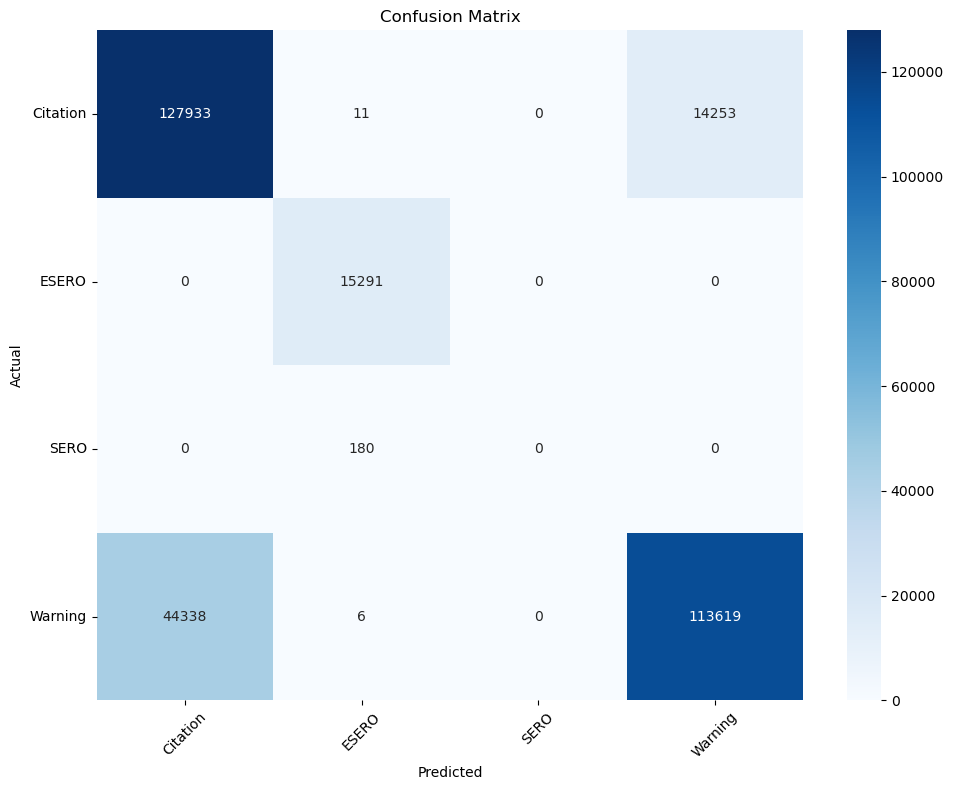

In [ ]:

# Display
print(f"Accuracy:  {bacc:.4f}")
print(f"Precision: {bprec:.4f}")
print(f"Recall:    {brec:.4f}")
print(f"F1 Score:  {bf1:.4f}")
print("Confusion Matrix:")
labels = bclf.classes_.to_arrow().to_pylist()  #

plt.figure(figsize=(10, 8))
sns.heatmap(bcm, annot=True, fmt='d', cmap='Blues', xticklabels=encoding, yticklabels=encoding)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from cuml.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

n_trees_range = [10, 50, 100, 150, 200]
accuracies = []
precisions = []
recalls = []
f1s = []
#iterates throught eh list of number of trees and depth 10 and stores their metrics
for n_trees in n_trees_range:
    clf = RandomForestClassifier(n_estimators=n_trees, max_depth=10)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc, prec, rec, f1 = evaluate_model(
        y_test.to_arrow().to_pylist(),
        y_pred.to_arrow().to_pylist()) 
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    #print(f"Trees: {n_trees}, Accuracy: {acc:.4f}")

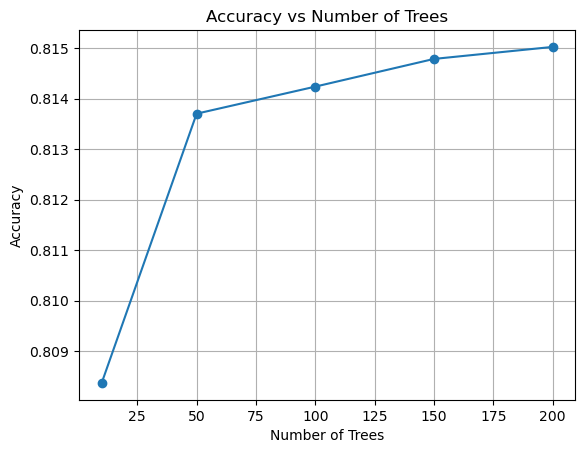

In [ ]:

plt.plot(n_trees_range, accuracies, marker='o')
plt.title("Accuracy vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

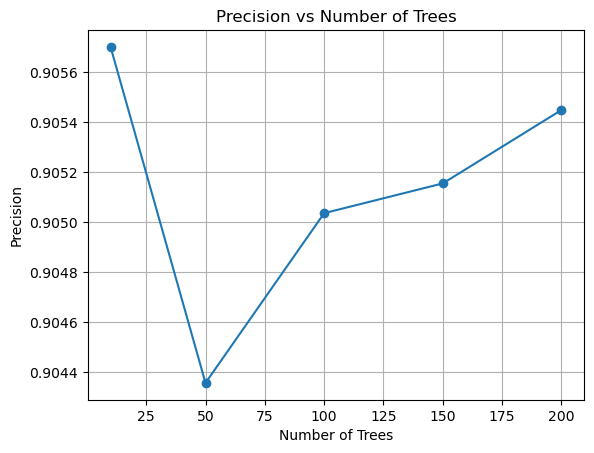

In [20]:
plt.plot(n_trees_range, precisions, marker='o')
plt.title("Precision vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

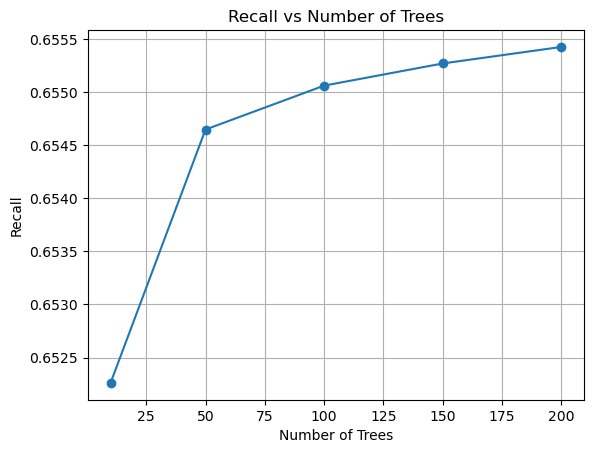

In [21]:
plt.plot(n_trees_range, recalls, marker='o')
plt.title("Recall vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Recall")
plt.grid(True)
plt.show()

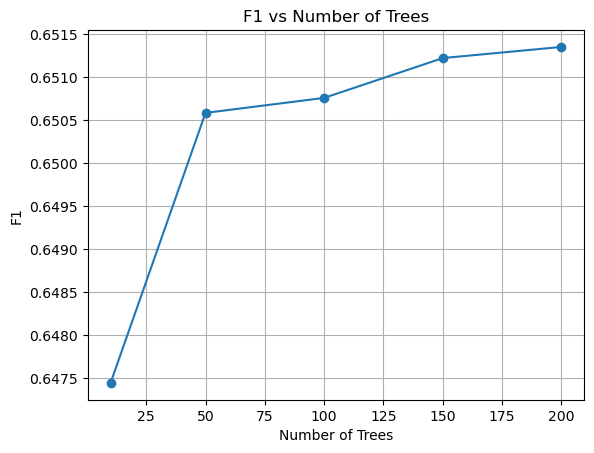

In [22]:
plt.plot(n_trees_range, f1s, marker='o')
plt.title("F1 vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("F1")
plt.grid(True)
plt.show()

In [ ]:
depths = list(range(2, 22, 2))  # Try depths from 2 to 20
accuracies = []
precisions = []
recalls = []
f1s = []
#for each depth from 2-20 incrementing by 2s, make random forests of n estimators 100 and save their metrics
for d in depths:
    clf = RandomForestClassifier(n_estimators=100, max_depth=d)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    acc, prec, rec, f1 = evaluate_model(
        y_test.to_arrow().to_pylist(),
        y_pred.to_arrow().to_pylist()) 
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    #print(f"Max Depth: {d}, Accuracy: {acc:.4f}")

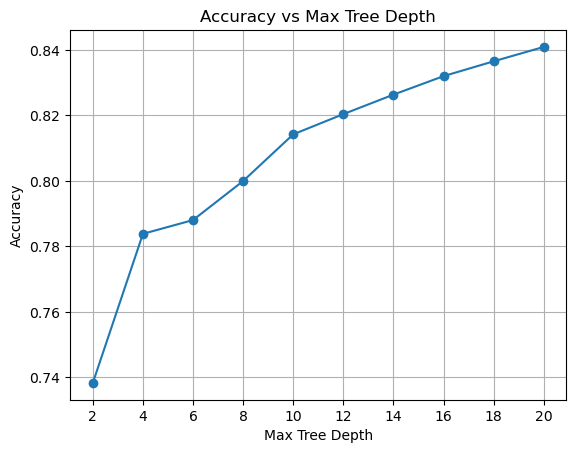

In [30]:
# Plot
plt.plot(depths, accuracies, marker="o")
plt.title("Accuracy vs Max Tree Depth")
plt.xlabel("Max Tree Depth")
plt.ylabel("Accuracy")
plt.xticks(depths)
plt.grid(True)
plt.show()

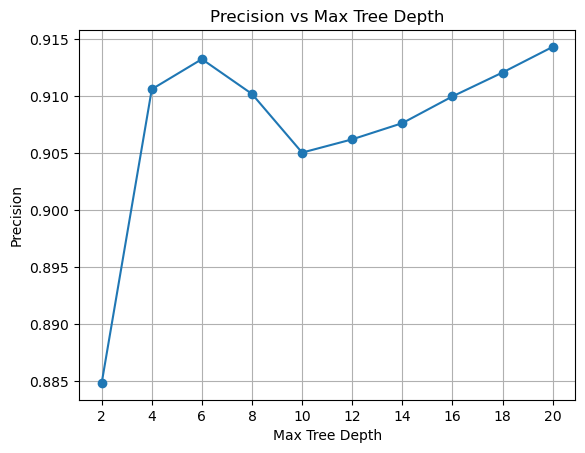

In [29]:
plt.plot(depths, precisions, marker="o")
plt.title("Precision vs Max Tree Depth")
plt.xlabel("Max Tree Depth")
plt.ylabel("Precision")
plt.xticks(depths)
plt.grid(True)
plt.show()

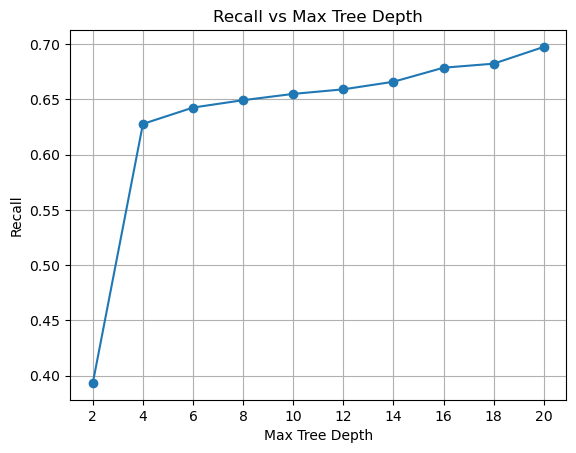

In [31]:
plt.plot(depths, recalls, marker="o")
plt.title("Recall vs Max Tree Depth")
plt.xlabel("Max Tree Depth")
plt.ylabel("Recall")
plt.xticks(depths)
plt.grid(True)
plt.show()

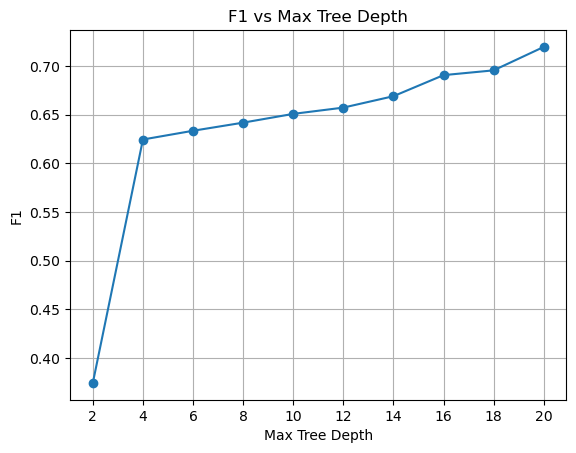

In [32]:
plt.plot(depths, f1s, marker="o")
plt.title("F1 vs Max Tree Depth")
plt.xlabel("Max Tree Depth")
plt.ylabel("F1")
plt.grid(True)
plt.xticks(depths)
plt.show()

In [ ]:
#clean memory
import gc
gc.collect()

0

In [ ]:
# found best performance
optimaldepth = 20
optimaln = 150

oclf = RandomForestClassifier(n_estimators=optimaln, max_depth=optimaldepth)
oclf.fit(X_train, y_train)
    
y_pred = oclf.predict(X_test)
acc, prec, rec, f1 = evaluate_model(
    y_test.to_arrow().to_pylist(),
    y_pred.to_arrow().to_pylist()) 

In [50]:
y_pred = oclf.predict(X_test).to_numpy()
y_true = y_test.to_numpy()
gc.collect()

89

In [51]:
# Calculate metrics
acc, prec, rec, f1 = evaluate_model(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

Accuracy:  0.8396
Precision: 0.9132
Recall:    0.6845
F1 Score:  0.6982
Confusion Matrix:


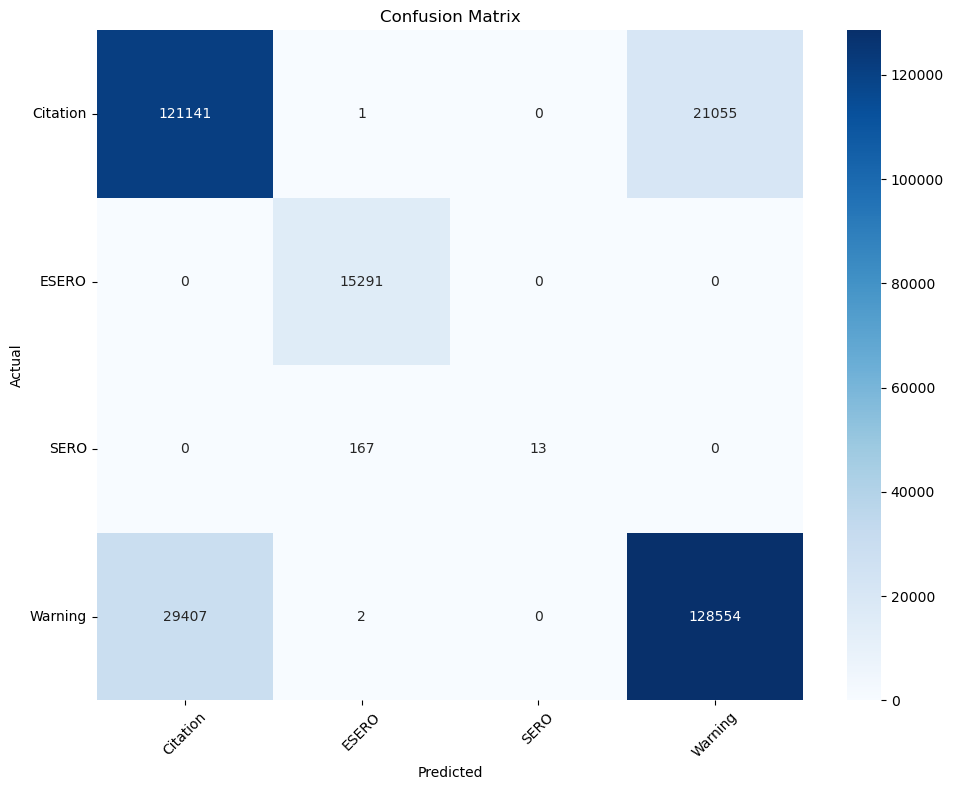

In [ ]:
# Display
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
labels = oclf.classes_.to_arrow().to_pylist()  

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoding, yticklabels=encoding)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
def permutation_importance(model, X_val, y_val, metric=accuracy_score, n_repeats=1):
    #you can put a certain metric (accuracy, precision, etc.), the X, y, and the trained model. It will calculate the model of full model on x and y
    baseline_score = metric(y_val.to_arrow().to_pylist(), model.predict(X_val).to_arrow().to_pylist())

    importances = cp.zeros(X_val.shape[1])
    X_val_copy = X_val.copy(deep=True)
    #goes through each column and tries to predict wihtout that column    
    for col_idx, col in enumerate(X_val.columns):
        scores = []
        for _ in range(n_repeats):
            shuffled = X_val_copy[col].to_pandas().sample(frac=1.0, random_state=42).reset_index(drop=True)
            shuffled = cudf.Series(shuffled.values, index=X_val_copy.index)
            #shuffles that feature
            
            X_val_copy[col] = shuffled
            try:
                #effively seperated the model from the current feature
                y_pred = model.predict(X_val_copy)
                score = metric(y_val.to_arrow().to_pylist(), y_pred.to_arrow().to_pylist())
                scores.append(score)
                #see what the metric score is when that feature is scrambled
            except ValueError:
                scores.append(baseline_score) #skip null
            
            X_val_copy[col] = X_val[col]  # Restore original

        # the importance is gained by subtracting the feature scramble score from baseline score
        importances[col_idx] = baseline_score - cp.mean(cp.asarray(scores))

    return cudf.DataFrame({
        'feature': X_val.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

In [ ]:
#running on a tree of depth 6 and ntrees of 200
clf = RandomForestClassifier(n_estimators=optimaln, max_depth=optimaldepth)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc, prec, rec, f1 = evaluate_model(
    y_test.to_arrow().to_pylist(),
    y_pred.to_arrow().to_pylist()) 

y_pred = clf.predict(X_test).to_numpy()
y_true = y_test.to_numpy()

importances_df = permutation_importance(clf, X_test, y_test)
print(importances_df)



                    feature  importance
16           search_outcome    0.270360
24                  article    0.088036
14         search_conducted    0.003507
2                  latitude    0.002284
3                 longitude    0.002199
1                 subagency    0.001457
27                   gender    0.001321
22                     year    0.001014
20                    state    0.000931
26                     race    0.000840
7           property_damage    0.000260
6           personal_injury    0.000187
25  contributed_to_accident    0.000168
32                 time_sin    0.000168
33                 time_cos    0.000162
4                  accident    0.000155
5                     belts    0.000114
17            search_reason    0.000105
29                 dl_state    0.000098
15       search_disposition    0.000073
19     search_arrest_reason    0.000060
21              vehicletype    0.000038
9        commercial_license    0.000025
12                  alcohol    0.000019


In [ ]:
# these features are not only overrepresented in the decision trees, they are also omnicient when used for prediction
overrepresented_features = ['search_outcome', 'article', 'search_conducted']
filtered_df = importances_df[~importances_df['feature'].isin(overrepresented_features)]

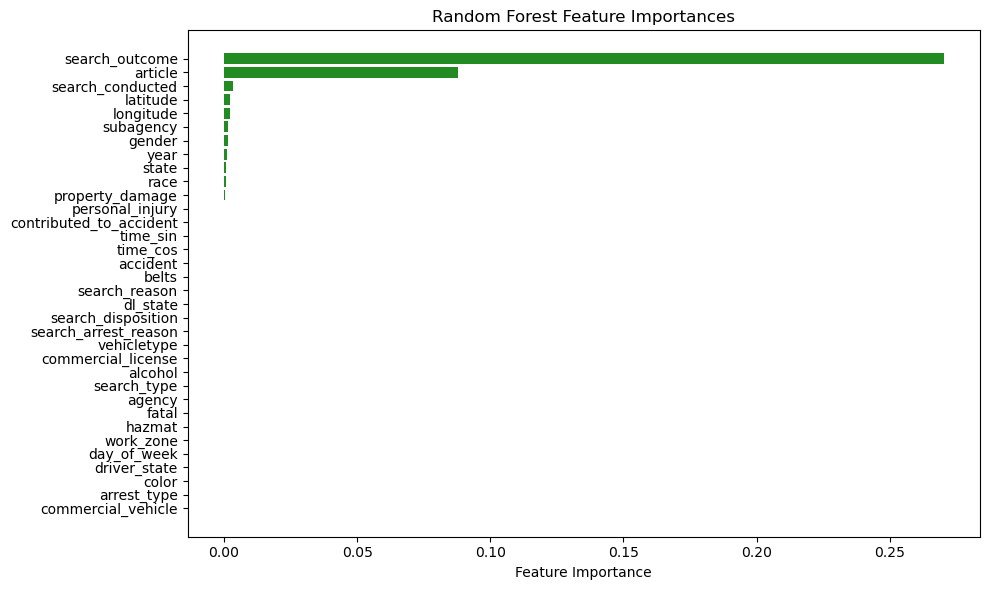

In [37]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].to_arrow().to_pylist(), importances_df['importance'].to_arrow().to_pylist(), color='forestgreen')
plt.gca().invert_yaxis()  # Most important on top
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

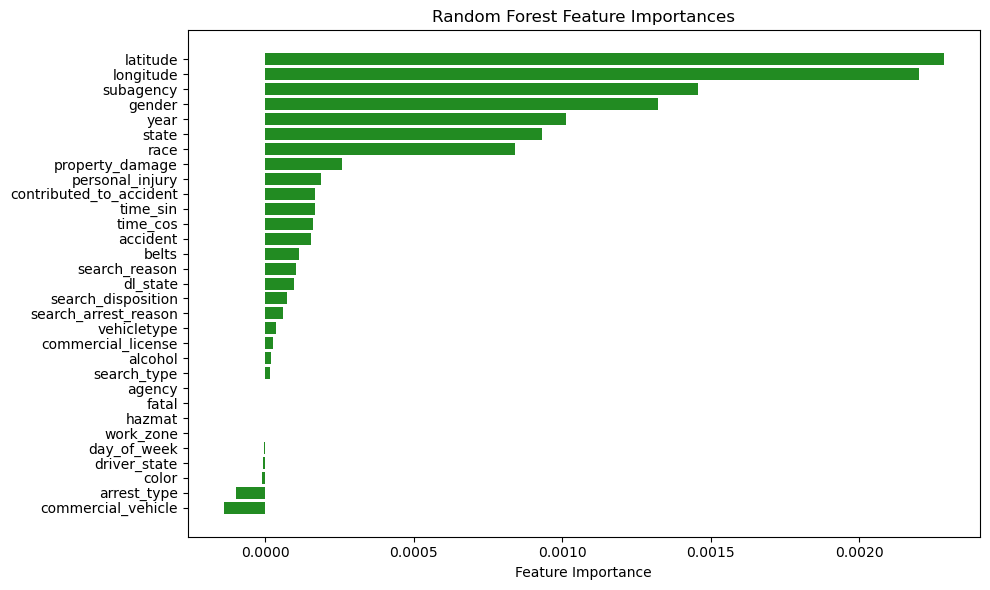

In [38]:
plt.figure(figsize=(10, 6))
plt.barh(filtered_df['feature'].to_arrow().to_pylist(), filtered_df['importance'].to_arrow().to_pylist(), color='forestgreen')
plt.gca().invert_yaxis()  # Most important on top
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()